In [1]:
%matplotlib notebook
import numpy as np
import orbipy as op
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import pickle

In [2]:
halo = pd.read_csv('halo family SE L1.txt', sep=' ', header=None)
halo.columns = ['x', 'z', 'vy']
halo['z'] = -1*halo['z']

In [3]:
halo.head()

,x,z,vy
0,0.991612,-0.000068,-0.009585
1,0.991615,-0.000177,-0.009596
2,0.991618,-0.000240,-0.009606
3,0.991621,-0.000290,-0.009616
4,0.991624,-0.000333,-0.009626


In [4]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/nd')
scaler = plotter.scaler

halo = halo.loc[~halo.apply(np.round, args=[9]).duplicated()]

## Кривая северных гало орбит в плоскости XZ

<IPython.core.display.Javascript object>


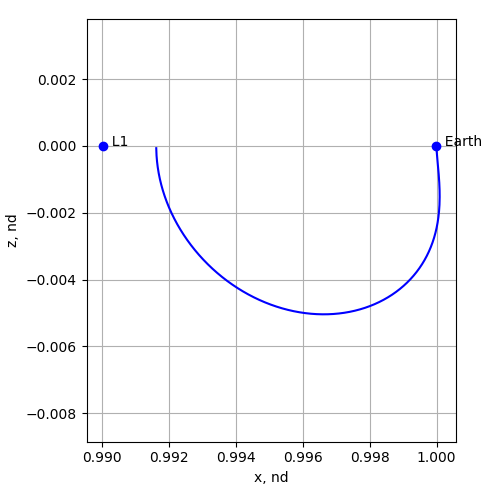

(0.989525663800155,
 1.0005979159136669,
 -0.005292228225797838,
 0.00025201086789513515)

In [121]:
ax = plotter.plot_proj(projections=['x-z'], plottables=[plotter.m, plotter.L1], marker='o')
ax.plot(halo['x'], halo['z'], 'b')
ax.grid(True)
plt.axis('equal')

In [93]:
class MinDistanceProblem:
    def __init__(self, halo_curve):
        self.spl = op.lines.spline.cubic(halo_curve.to_numpy(), usecols=[0, 1])
        self.dc = op.differential_correction.from_preset(stm_model, 'halo')
        self.center = np.array([(halo_curve.iloc[0]['x']+halo_curve.iloc[-1]['x'])*0.5, 0.0])
        self.vec_axis = np.array([model.mu1 - self.center[0], 0.])
        self.plane = op.eventY(count=2)
        self.det = op.event_detector(precise_model, [self.plane])
        
    def calc_angle(self, a, b):
        vec_orb = np.array([a - self.center[0], b]) # np.array([a, b]) - np.array([self.center, 0.])
        return np.degrees(np.arccos(np.dot(vec_orb, self.vec_axis)/(self.norm(vec_orb)*self.norm(self.vec_axis))))
        
    def norm(self, vec):
        return np.linalg.norm(vec)
        
    def min_distance(self, orb, dt, t_step=scaler(12, 'h-nd')):
        x_int = sp.interpolate.interp1d(orb['t'], orb['x'], kind='cubic')
        y_int = sp.interpolate.interp1d(orb['t'], orb['y'], kind='cubic')
        z_int = sp.interpolate.interp1d(orb['t'], orb['z'], kind='cubic')

        distances = []

        t_early = 0.0
        t_late = dt
        max_t = orb.iloc[-1]['t']

        while t_late < max_t:
            state_early = np.array([x_int(t_early), y_int(t_early), z_int(t_early)])
            state_late = np.array([x_int(t_late), y_int(t_late), z_int(t_late)])

            distances.append(np.linalg.norm(state_late - state_early))

            t_early += t_step
            t_late += t_step

        return min(distances)
    
    def calc_orbit(self, length):
        x0, z0, vy0 = self.spl(length)
        alpha = self.calc_angle(x0, z0)
        s0 = self.dc.shoot(np.array([x0, 0., z0, 0., vy0, 0.]), alpha)[:6]
        orb, ev = self.det.prop(s0, 0.0, 100, last_state='last')
        return orb, ev

    def min_distance_length(self, length):
        orb, ev = self.calc_orbit(length)
        half_period = ev.iloc[-1]['t']*0.5
        return self.min_distance(orb, half_period)
    
    def target(self, length):
        return -1.*self.min_distance_length(length)

In [94]:
mdp = MinDistanceProblem(halo)

In [95]:
ls = np.linspace(0., 1., 500)
ds = np.array([mdp.min_distance_length(l) for l in ls])

### Временная задержка между КА соответсвуте времени половины оборота на гало орбите.
### Кривая гало орбит была параметризована одним параметром - длиной.
## График функции минимального расстояния между КА в зависимости от длины на кривой (от начальных условий).

<IPython.core.display.Javascript object>


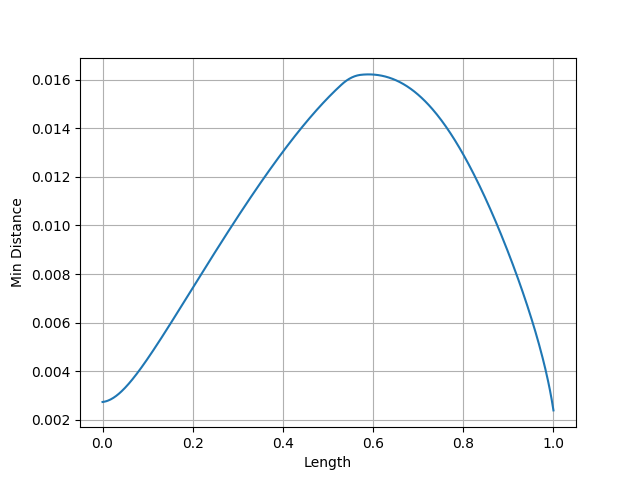

In [101]:
plt.plot(ls, ds)
plt.xlabel('Length')
plt.ylabel('Min Distance')
plt.grid(True)

In [97]:
result = sp.optimize.fminbound(mdp.target, 0.0, 1.0, xtol=1e-10, full_output=True)

In [98]:
result

(0.589895796840973, -0.01621258564607599, 0, 31)

In [116]:
orb, ev = mdp.calc_orbit(result[0])

## Начальные условия доставляющие максимум функционалу "Минимальное расстояние между КА"

<IPython.core.display.Javascript object>


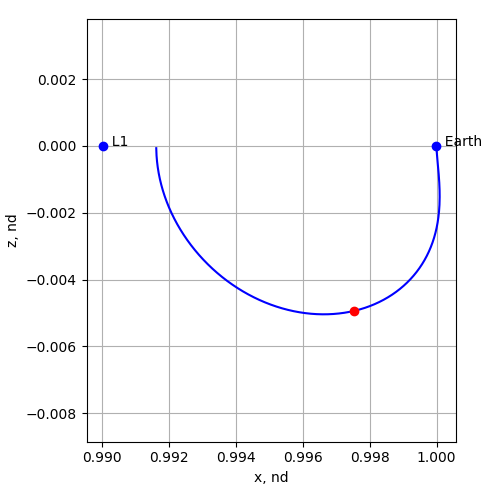

(0.989525663800155,
 1.0005979159136669,
 -0.005292228225797838,
 0.00025201086789513515)

In [122]:
ax = plotter.plot_proj(projections=['x-z'], plottables=[plotter.m, plotter.L1], marker='o')
ax.plot(halo['x'], halo['z'], 'b')
ax.plot(orb.iloc[0]['x'], orb.iloc[0]['z'], 'ro')
ax.grid(True)
plt.axis('equal')

## Оптимальная орбита

<IPython.core.display.Javascript object>


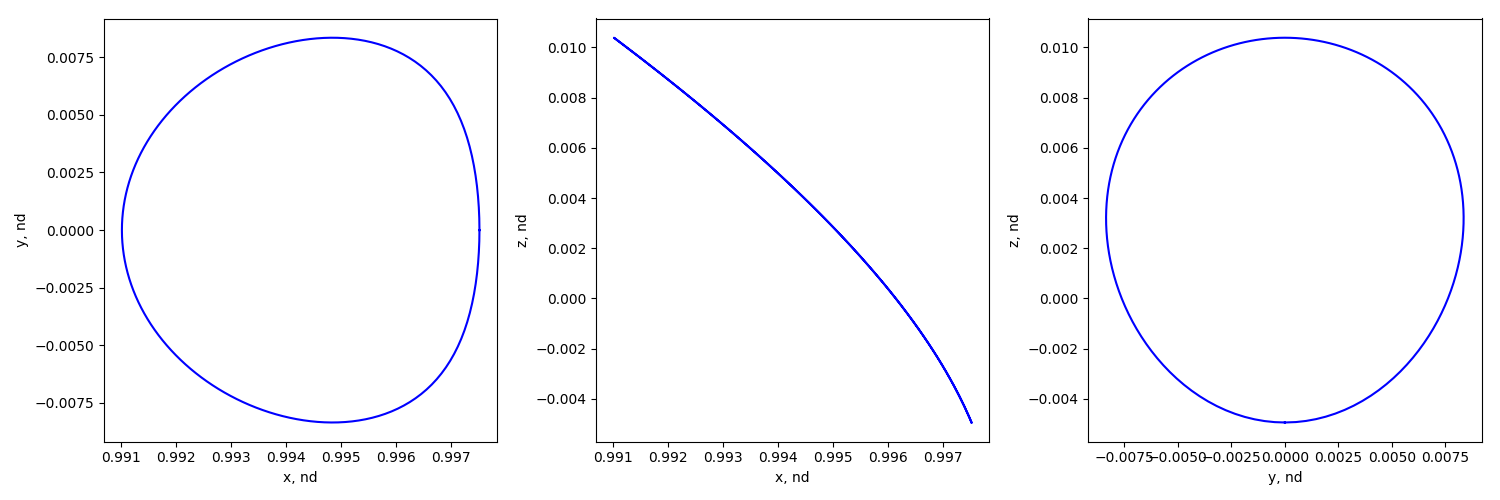

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40ddfa5eb8>,
      dtype=object)

In [113]:
plotter.plot_proj(orb)

## Минимальное расстояние между КА на оптимальной орбите

In [114]:
scaler(-1.*result[1], 'nd-km')

2425402.812652968

In [125]:
orb.iloc[0].values[1:]

array([ 0.99752574,  0.        , -0.00493959,  0.        , -0.02724067,
        0.        ])